In [ ]:
import dos
from IPython.display import Image
path = './dos/Integrated_SoftDrive'

In [ ]:
# init
sim = dos.DOS(path, 20, show_timing = 2)
Image(filename=path + '/timing.png')

In [ ]:
sim.start()

In [ ]:
sim.pctComplete

In [ ]:
sim.join()
sim.terminate()

logs = sim.logs.entries

In [1]:
# Save
import pickle

# Integrated_SoftDrive_NoMount
# Integrated_SoftDrive_NoMount_wAc
# Integrated_SoftDrive_wMwA_10
# Integrated_SoftDrive_wMwA_30

"""
with open('./logs/Integrated_SoftDrive_wMwA_30.sclogs', 'wb') as f:
    pickle.dump(sim.logs.entries, f)
    logs = sim.logs.entries
"""
"""
# Load
logs = pickle.load( open( './logs/Integrated_SoftDrive_wMwA_30.sclogs', "rb" ) )
"""
;

# plot logs
---

In [2]:
import matplotlib.pyplot as plt
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    pass

import numpy as np

try:
    duration = sim.cfg['simulation']['duration']
except NameError:
    duration = logs['FEM']['OSS_AzDrive_D'].timeSeries[0][-1]
    
xticks = np.arange(0, duration + 1, duration/ 10)

logs

{'wfs48': {'M12_RBM': <dos.dos.Entry at 0x7f77b0fa5e10>},
 'AcO_controller': {'M1 TxyzRxyz': <dos.dos.Entry at 0x7f77808380d0>,
  'M2 Txyz': <dos.dos.Entry at 0x7f77808382d0>,
  'M2 Rxyz': <dos.dos.Entry at 0x7f77808384d0>,
  'M1 BM': <dos.dos.Entry at 0x7f77808386d0>},
 'M1Pos0': {'M1Pos_DeltaF': <dos.dos.Entry at 0x7f7780838910>},
 'Mount': {'Mount_AzDrive_F': <dos.dos.Entry at 0x7f7773e90d10>,
  'Mount_ElDrive_F': <dos.dos.Entry at 0x7f776b888ed0>,
  'Mount_GIRDrive_F': <dos.dos.Entry at 0x7f776fdaf090>},
 'M1HPloadcells0': {'M1_HP_F_meas': <dos.dos.Entry at 0x7f775b419290>},
 'FEM': {'OSS_AzDrive_D': <dos.dos.Entry at 0x7f774fa07490>,
  'OSS_ElDrive_D': <dos.dos.Entry at 0x7f776374f650>,
  'OSS_GIRDrive_D': <dos.dos.Entry at 0x7f773cdde810>,
  'OSS_Hardpoint_D': <dos.dos.Entry at 0x7f7735f4b9d0>,
  'Bending Modes': <dos.dos.Entry at 0x7f773037ab90>,
  'OSS_M1_Translation': <dos.dos.Entry at 0x7f772a388490>,
  'OSS_M1_Rotation': <dos.dos.Entry at 0x7f7721266d90>}}

In [3]:
time_1 = logs['FEM']['OSS_AzDrive_D'].timeSeries[0]
time_2000 = logs['wfs48']['M12_RBM'].timeSeries[0]
time_50000 = logs['AcO_controller']['M1 BM'].timeSeries[0]

AcO_ref = logs['AcO_controller']['M1 TxyzRxyz'].timeSeries[1]
FEM_Txyz = logs['FEM']['OSS_M1_Translation'].timeSeries[1]
FEM_Rxyz = logs['FEM']['OSS_M1_Rotation'].timeSeries[1]
FEM_HP_D = logs['FEM']['OSS_Hardpoint_D'].timeSeries[1]

Mount_Az = logs['Mount']['Mount_AzDrive_F'].timeSeries[1]
Mount_El = logs['Mount']['Mount_ElDrive_F'].timeSeries[1]
Mount_GIR = logs['Mount']['Mount_GIRDrive_F'].timeSeries[1]

FEM_Az = logs['FEM']['OSS_AzDrive_D'].timeSeries[1]
FEM_El = logs['FEM']['OSS_ElDrive_D'].timeSeries[1]
FEM_GIR = logs['FEM']['OSS_GIRDrive_D'].timeSeries[1]

HP_F = logs['M1Pos0']['M1Pos_DeltaF'].timeSeries[1]

HP_loadcells = logs['M1HPloadcells0']['M1_HP_F_meas'].timeSeries[1].T

In [4]:
import scipy.io as scio
from scipy.linalg import inv as scinv

fullHpK = scio.loadmat('/home/felipe/Documents/GMTO/SimulinkDrivers/fullHpK.mat')['fullHpK']
CG2HP = scio.loadmat('/home/felipe/Documents/GMTO/SimulinkDrivers/CG2HP.mat')['gc2hp_cell']

HP2CG = np.empty(CG2HP.shape, dtype = object)
for s in range(7):
    HP2CG[0, s] = scinv(CG2HP[0, s])

In [5]:
# Calculate HP rbm 

TS = int(duration*2000+1)
FEM_hpDeltaL = np.zeros([7, 6, TS])
HP_rbm =  np.zeros([7, 6, TS])

vec_1 = np.ones([1,6], dtype = int) * 12

for seg in range(7):
    cell = (np.arange(0,6) + vec_1 * seg)[0]
    mirror = (np.arange(6,12) + vec_1 * seg)[0]
    FEM_hpDeltaL[seg,:,:] = ( FEM_HP_D[:,mirror]  - FEM_HP_D[:,cell] ).T
    
    HP_rbm[seg,:,:] = np.dot(HP2CG[0,seg], FEM_hpDeltaL[seg,:,:])

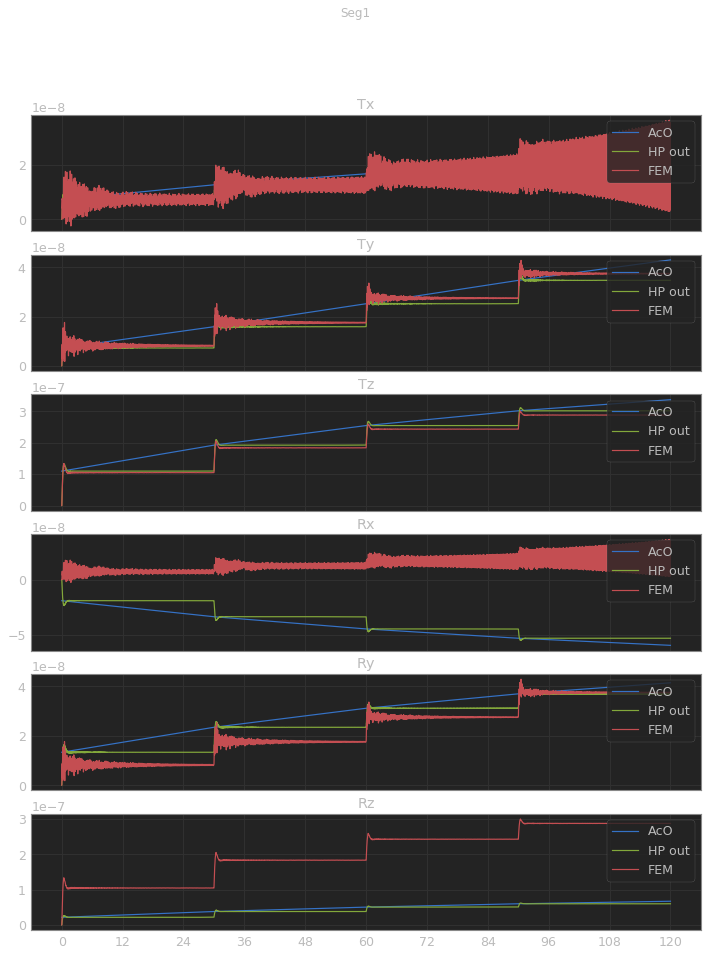

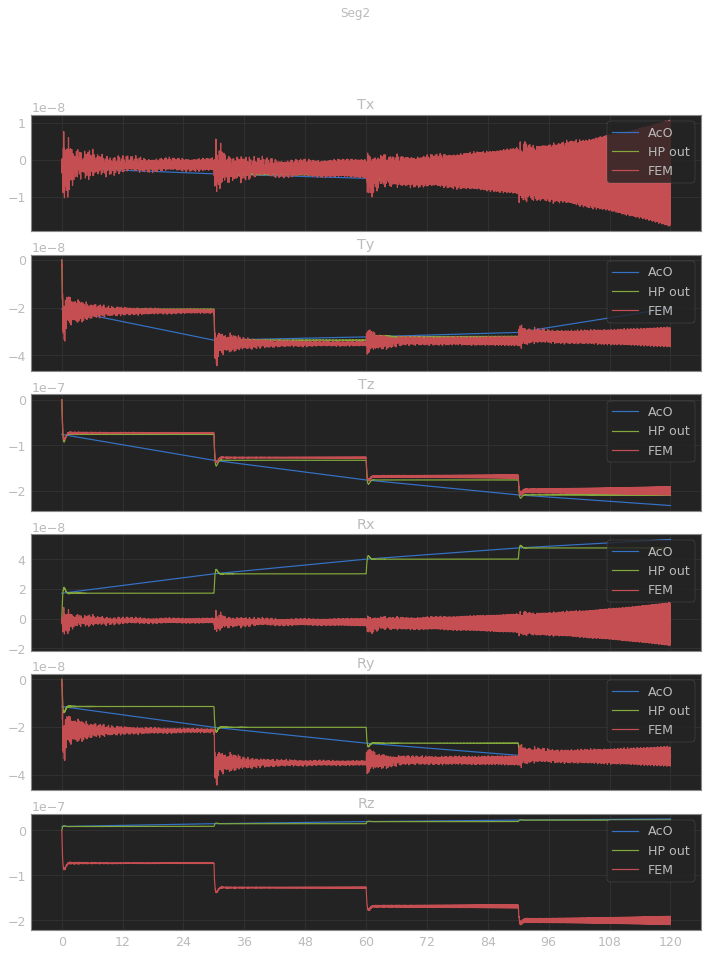

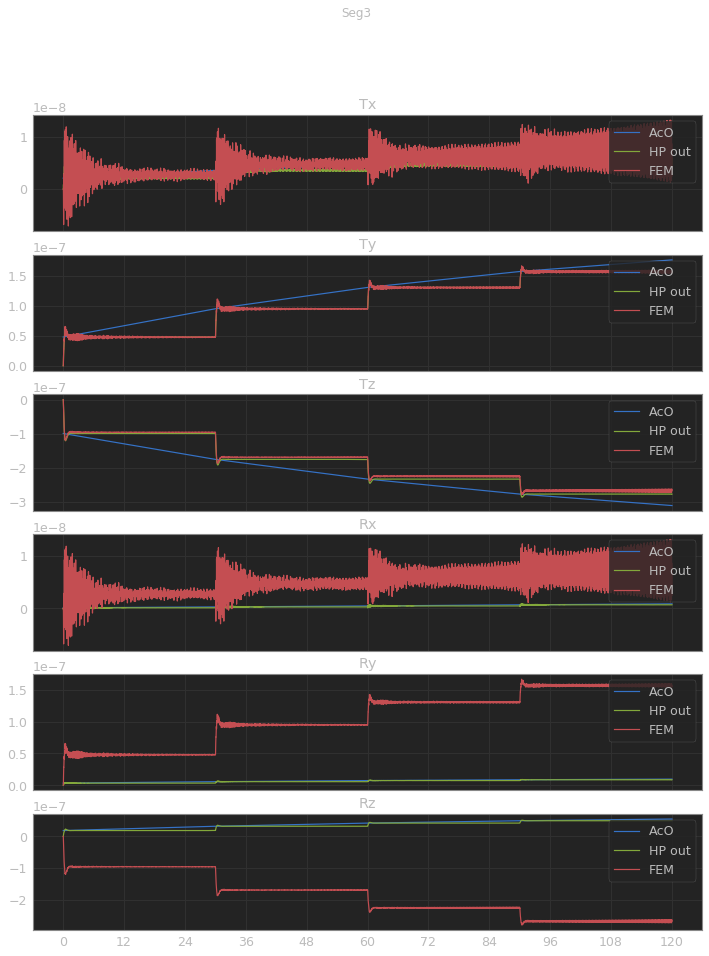

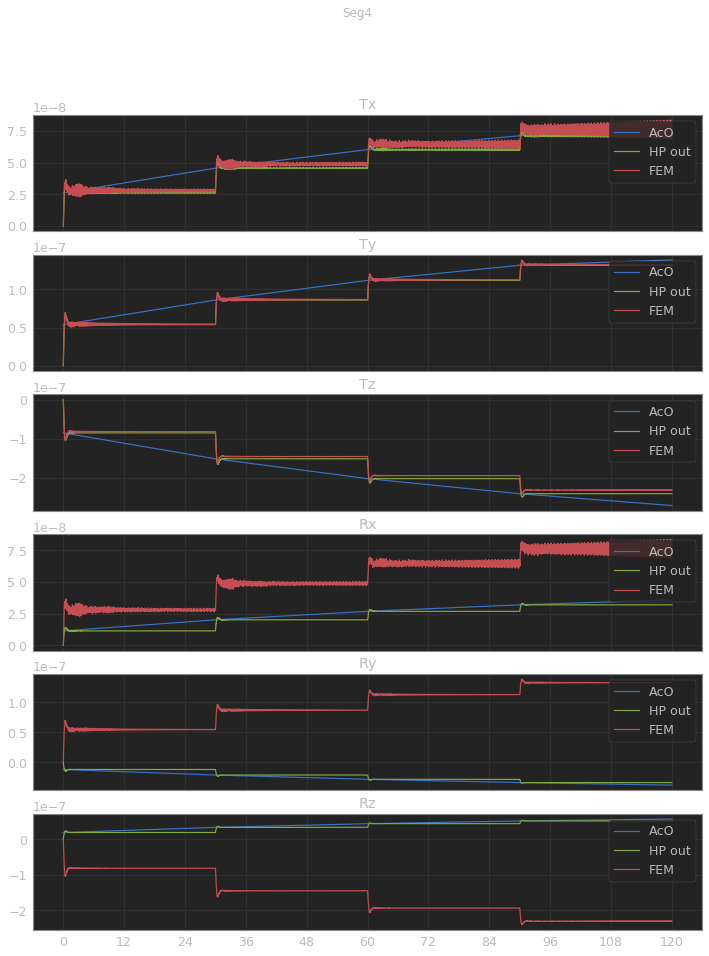

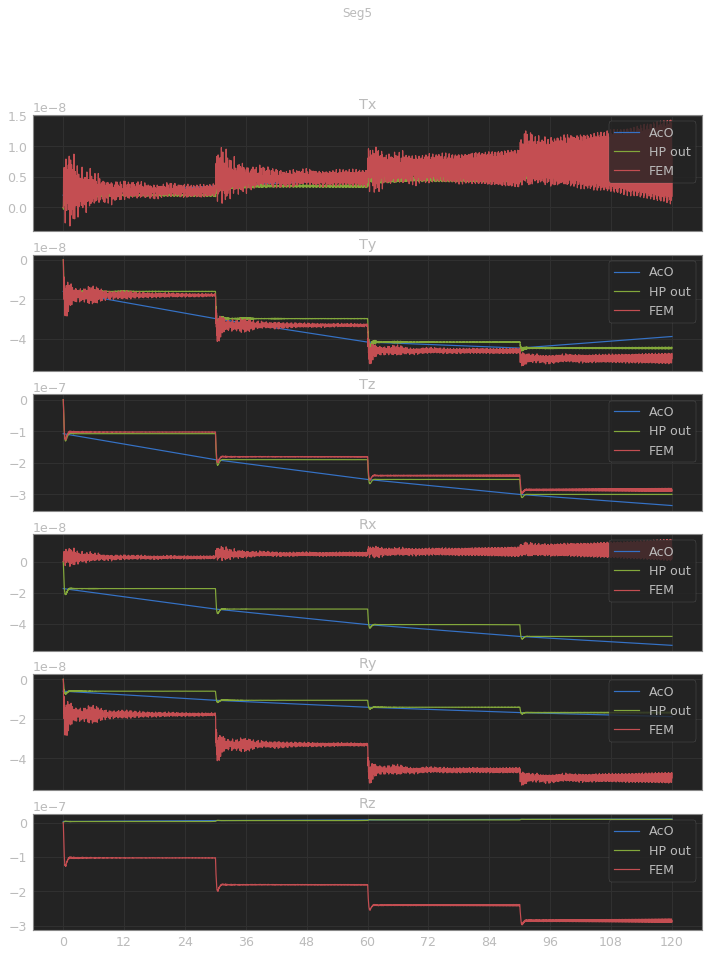

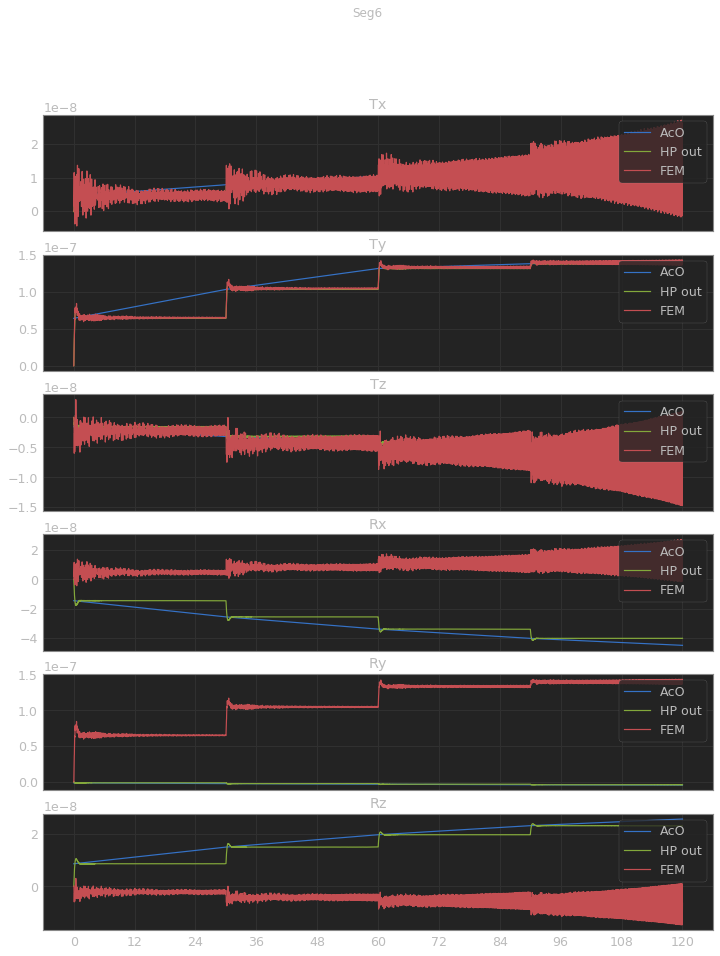

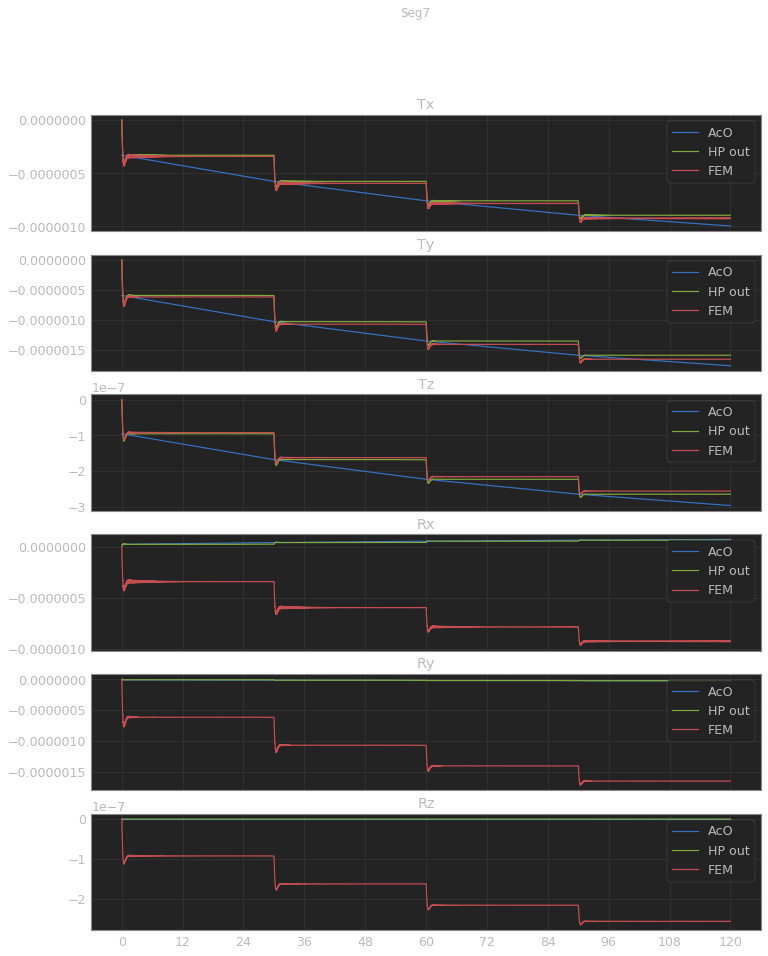

In [6]:
seg = list(range(7))
TRxyz = list(range(6))
rbm_str = ['Tx','Ty','Tz','Rx','Ry','Rz']
for s in seg:
    fig, ax = plt.subplots(6, 1, sharex=True, figsize=(12,15))
    fig.suptitle('Seg'  + str(s + 1), fontsize=12, horizontalalignment = 'center',
                verticalalignment = 'top')
    for rbm in TRxyz:
        ax[rbm].plot(time_1[::60000], AcO_ref[s,rbm,:], label = 'AcO')
        ax[rbm].plot(time_1, HP_rbm[s,rbm,:], label = 'HP out' ) 
        #ax[rbm].plot(time_1, FEM_out[:,s * 6  + rbm], label = 'FEM')
        if rbm <3:
            ax[rbm].plot(time_1, FEM_Txyz[s,rbm, :], label = 'FEM')
        else:
            ax[rbm].plot(time_1, FEM_Txyz[s,rbm - 3, :], label = 'FEM')
        ax[rbm].set_xticks(xticks)
        ax[rbm].set_title(rbm_str[rbm])
        ax[rbm].legend(loc="upper right")
        #ax[rbm].set_xlim([0, 10])
        #ax[rbm].set_ylim([-1e-6, 1e-6])
    plt.show()

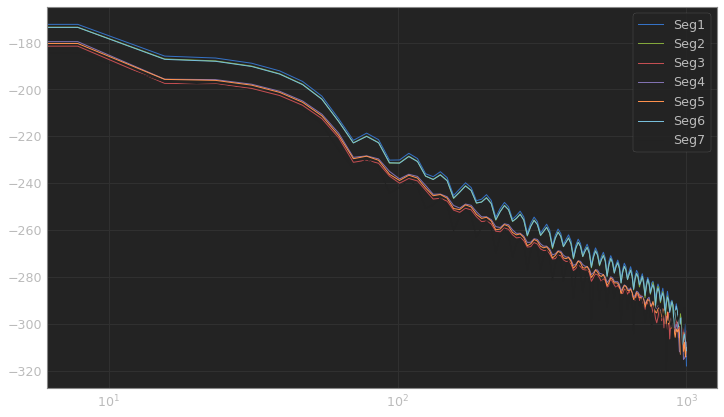

In [47]:
import scipy.signal as scs

plt.figure(figsize = (12,7))
freq_resp = [np.abs(scs.spectrogram( FEM_Txyz[x,0, :], fs=2000, mode = 'magnitude')) for x in range(0,7)]
for x in range(len(freq_resp)):
    plt.semilogx(freq_resp[x][0],20*np.log10(freq_resp[x][2][:,-1]), lw=1, label = 'Seg'+str(x + 1))
    plt.legend()
plt.show()

In [ ]:
for seg in range(7):
    fig, ax = plt.subplots(2,3, figsize = (12,7))
    fig.suptitle('Seg'  + str(seg + 1), fontsize=12, horizontalalignment = 'center',
                verticalalignment = 'top')
    for i in range(6):
        if i < 3:
            ax[0, i].plot(time_1, HP_loadcells[i+6*seg,:])
            ax[0, i].set_title(rbm_str[i])
        else:
            ax[1, i-3].plot(time_1, HP_loadcells[i+6*seg,:])
            ax[0, i-3].set_title(rbm_str[i])
plt.show()

In [ ]:
invHpK = scinv(fullHpK)
HP_deltaL = np.dot(invHpK, HP_F.T)

In [ ]:
FEM_TRxyz = np.concatenate([FEM_Txyz, FEM_Rxyz], axis = 1)
FEM_TRxyz.shape

ref_dl = np.zeros([7,6,FEM_TRxyz.shape[2]])
for s in range(7):
    ref_dl[s,:,:] = np.dot(CG2HP[0,s], FEM_TRxyz[s,:,:])

In [ ]:
seg = list(range(7))
TRxyz = list(range(6))
rbm_str = ['Tx','Ty','Tz','Rx','Ry','Rz']
for s in seg:
    fig, ax = plt.subplots(6, 2, sharex=True, figsize=(12,15))
    fig.suptitle('Seg'  + str(s + 1), fontsize=12, horizontalalignment = 'center',
                verticalalignment = 'top')
    for rbm in TRxyz:
        ax[rbm,0].plot(time_1, HP_F[:,s*6 + rbm], '--')
        ax[rbm,1].plot(time_1, HP_deltaL[s*6 + rbm,:], '--')
        if rbm <3:
            ax[rbm,1].plot(time_1, ref_dl[s,rbm, :], label = 'FEM')
        else:
            ax[rbm,1].plot(time_1, ref_dl[s,rbm - 3, :], label = 'FEM')

In [ ]:
HP_D = logs['FEM']['OSS_Hardpoint_D'].timeSeries[1].T
HP_D.shape

In [ ]:
HP1_cell = HP_D[0:6, :]
HP1_mirror = HP_D[6:12,:]
HP_DeltaD = HP1_mirror - HP1_cell
plt.figure(figsize = (12,5))
plt.plot(HP_DeltaD.T * 2.3124e+08)
plt.show()

In [ ]:
seg = list(range(7))
hp_ = list(range(6))
for s in seg:
    fig, ax = plt.subplots(6, 1, sharex=True, figsize=(12,15))
    fig.suptitle('Seg'  + str(s + 1), fontsize=12, horizontalalignment = 'center',
                verticalalignment = 'top')
    for hp in hp_:
        ax[hp].plot(time_1, HP_F[:,s * 6  + hp])
        ax[hp].set_xticks(xticks)
        ax[hp].set_title(f'Hardpoint {hp + 1} Delta F')
        #ax[hp].legend(loc="best")
    plt.show()

In [ ]:
wfs = logs['wfs48']['M12_RBM'].timeSeries[1]

plt.figure(figsize = (15,7))
plt.plot(wfs)
plt.show()

In [45]:
AzimuthM = (Mount_Az[:,0] + Mount_Az[:,1] + Mount_Az[:,2] + Mount_Az[:,3] 
- Mount_Az[:,4] - Mount_Az[:,5] -  Mount_Az[:,6] - Mount_Az[:,7])/4

ElevationM = (Mount_El[:,0] + Mount_El[:,1] + Mount_El[:,2] + Mount_El[:,3] 
- Mount_El[:,4] - Mount_El[:,5] -  Mount_El[:,6] - Mount_El[:,7])/4

GIRM = (Mount_GIR[:,0] + Mount_GIR[:,1] - Mount_GIR[:,2] - Mount_GIR[:,3])/2

FEM_Azimuth = (FEM_Az[:,0] + FEM_Az[:,1] + FEM_Az[:,2] + FEM_Az[:,3] 
- FEM_Az[:,4] - FEM_Az[:,5] -  FEM_Az[:,6] - FEM_Az[:,7])/4

FEM_Elevation = (FEM_El[:,0] + FEM_El[:,1] + FEM_El[:,2] + FEM_El[:,3] 
- FEM_El[:,4] - FEM_El[:,5] -  FEM_El[:,6] - FEM_El[:,7])/4

FEM_GIR = (FEM_GIR[:,0] + FEM_GIR[:,1] - FEM_GIR[:,2] - FEM_GIR[:,3])/2

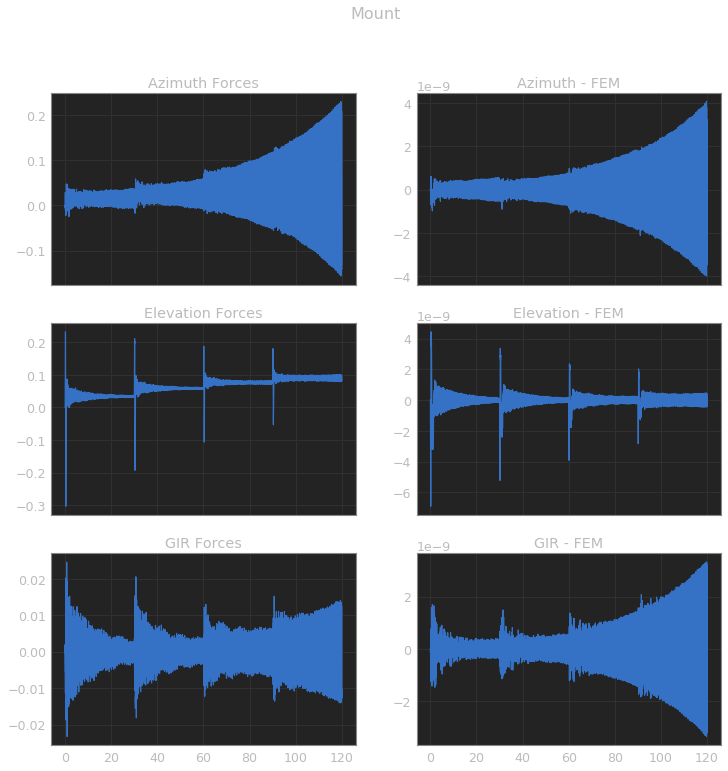

In [46]:
fig, ax = plt.subplots(3,2, sharex=True, figsize=(12,12))
fig.suptitle('Mount', fontsize=16, horizontalalignment = 'center',
                verticalalignment = 'top')
ax[0,0].plot(time_1, AzimuthM)
ax[0,0].set_title('Azimuth Forces')
ax[1,0].plot(time_1, ElevationM)
ax[1,0].set_title('Elevation Forces')
ax[2,0].plot(time_1, GIRM)
ax[2,0].set_title('GIR Forces')
ax[0,1].plot(time_1, FEM_Azimuth)
ax[0,1].set_title('Azimuth - FEM')
ax[1,1].plot(time_1, FEM_Elevation)
ax[1,1].set_title('Elevation - FEM')
ax[2,1].plot(time_1, FEM_GIR)
ax[2,1].set_title('GIR - FEM')
plt.show()

### Bending Modes
---

In [ ]:
BM = logs['FEM']['Bending Modes'].timeSeries[1].T

plt.figure(figsize = (15,7))
plt.plot(BM[:,:,0])
plt.show()

In [ ]:
import scipy.io as sio
transformation_path = '../database/bendingmodes/old_consolidated_SSBM_transformation_matrices.mat'
load_args = {'squeeze_me' : True, 'mat_dtype' : True}
Q_seg = sio.loadmat(transformation_path,variable_names = ['Q_incell'],
                   **load_args)['Q_incell']
U_seg = sio.loadmat(transformation_path, variable_names = ['U_incell'],
                    **load_args)['U_incell']

In [ ]:
import importlib
import utils
try:
    importlib.reload(utils)
except:
    pass
from utils import LargeCompute

lc = LargeCompute(onCuda = True)

disp_ptt_ = lc.load_disp('variables/states.dat', './dos/Integrated', int(duration) )

indx = [x*742 for x in range(1,7)]
disp_ptt = np.array(np.split(disp_ptt_, indices_or_sections = indx, axis = 0),
                     dtype = object)

disp = np.empty(7, dtype = object)
ptt = np.empty(7, dtype = object)
for i in range(7):
    disp[i], ptt[i] = lc.remove_ptt(Q_seg[i], disp_ptt[i])

In [ ]:
rec_disp = np.empty(7, dtype = object)
for i in range(7):
    rec_disp[i] = lc.bm_to_disp_time(U_seg[i][:,0:27] ,BM[:,:,i].T)

plt.figure(figsize = (10,10))
plt.subplot(211)
plt.plot(rec_disp[5][200,:])
plt.plot(disp[5][200,:], '--')
plt.subplot(212)
plt.plot(rec_disp[5][200,:] - disp[5][200,:])
plt.show()

displacements_ptt[:,:] = np.dot(C, states)

indc1 = [x*742 for x in range(1,7)]
seg_displacements_ptt_ = np.split(displacements_ptt,
                                             indices_or_sections = indc1,
                                             axis = 0)

disp_ptt = bm_utils.load_displacements('variables/states.dat',
                                       './dos/Integrated',
                                       int(duration))

In [ ]:
from bendingModes_utils import bending_modes
bm_utils = bending_modes(transformation_path)

fig, ax = plt.subplots(1,2, figsize = (20, 8))
ax1, ax2 = ax
bm_utils.plot_surf(rec_disp[1:2], 0, 300000)
#bm_utils.plot_surf(rec_disp, 0, 25000)

In [ ]:
rec_disp.shape